# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

import textwrap

In [70]:
# PATH = Path('data/wikitext/wikitext-2-raw')
PATH = Path('data/wikitext/wikitext-103-raw')

# CSV = PATH/'words.csv'

!ls {PATH}

wiki.test.raw  wiki.train.raw  wiki.valid.raw


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Helpers

In [5]:
def nonzero(pred):
    ints = to_np(pred).astype(int)
    return ints[np.nonzero(ints)]

def char_label_text(pred, chunk=70):
    st = ''.join([itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

def char_split_text(pred):
    return [itos[i] for i in nonzero(pred)]

def word_label_text(pred, chunk=70):
    st = ' '.join([w_itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

## WikiText

In [71]:
with open(PATH/'wiki.train.raw') as file:  
    trn = file.read()
with open(PATH/'wiki.valid.raw') as file:  
    val = file.read()
with open(PATH/'wiki.test.raw') as file:  
    tst = file.read()

In [72]:
len(trn)
# 2:    10918892
# 103: 539566975

539566975

### clean the text

In [73]:
# convert spaced out " strings " to "strings"
def despace(m):
    m = m.group(0)   # entire matched string
    m = m.replace('" ','"')
    m = m.replace(' "','"')
    return m

def cleanup(x):
    x = x.replace(' @-@ ', '-').replace(' =', '').replace('\n', '').replace(
        " \'", "\'").replace(' ,', ',').replace(' .', '.').replace(' :', ':').replace(' ;', ';').replace(
        '( ', '(').replace(' )', ')').replace('[ ', '[').replace(' ]', ']').replace(' @.@ ', '.').replace(
        ' @,@ ', ',')
    x = re.sub(r'\"(.+?)\"', despace, x)
    return x

In [74]:
trn = cleanup(trn)
val = cleanup(val)
tst = cleanup(tst)

In [78]:
trn = trn + tst
# len(trn)

518915110

## IAM chars

In [7]:
IAM_PATH = Path('data/IAM_handwriting')

In [18]:
maxTextLen = 32
samples = []
chars = set()

with open(IAM_PATH/'ascii/words.txt') as f:
    for line in f:
        # ignore comment line
        if not line or line[0]=='#':
            continue

        lineSplit = line.strip().split(' ')
        assert len(lineSplit) >= 9

        fileName = lineSplit[0]

        # GT text are columns starting at 9
        gtText = ''.join(lineSplit[8:])[:maxTextLen]
        char_len = len(gtText)
        chars = chars.union(set(list(gtText)))

        # put sample into list
        samples.append([fileName, gtText, char_len])
    
samples = np.stack(samples)
df = pd.DataFrame(samples, columns=['filename', 'word', 'char_len'], )
del samples

In [19]:
df['char_len'] = df.char_len.astype('int32')
# df = df.loc[df['char_len'] > 3]
df = df.loc[df['char_len'] < 20]
df.head()

,filename,word,char_len
0,a01-000u-00-00,A,1
1,a01-000u-00-01,MOVE,4
2,a01-000u-00-02,to,2
3,a01-000u-00-03,stop,4
4,a01-000u-00-04,Mr.,3


In [20]:
trn = ' '.join(df.word.values)
len(trn)

590841

In [32]:
val = trn[-60000:]   #last 60000
trn = trn[:-60000]

530841

## Str to idx

In [79]:
itos = pickle.load(open('data/IAM_handwriting/tmp/char_itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
len(itos)

82

In [80]:
#convert text into idxs
trn_idx = np.array([stoi[c] for c in trn])
val_idx = np.array([stoi[c] for c in val])
# tst_idx = np.array([stoi[c] for c in tst])

## Create ModelData object

In [81]:
class LMLoader():
    """ Returns a language model iterator that iterates through batches that are of length N(bptt,5)
    The first batch returned is always bptt+25; the max possible width.  This is done because of they way that pytorch
    allocates cuda memory in order to prevent multiple buffers from being created as the batch width grows.
    """
    def __init__(self, nums, bs, bptt, backwards=False):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        self.data = self.batchify(nums)
        self.i,self.iter = 0,0
        self.n = len(self.data)
        
    def __iter__(self):
        self.i,self.iter = 0,0
        while self.i < self.n-1 and self.iter<len(self):
            if self.i == 0:
                seq_len = self.bptt + 5 * 5
            else:
                bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
                seq_len = max(5, int(np.random.normal(bptt, 5)))
            res = self.get_batch(self.i, seq_len)       
            self.i += seq_len
            self.iter += 1
            yield res

    def __len__(self): return self.n // self.bptt - 1
    
    def batchify(self, data):
        nb = data.shape[0] // self.bs
        data = np.array(data[:nb*self.bs])
        data = data.reshape(self.bs, -1).T
        return T(data)
    
    def get_batch(self, i, seq_len):
        source = self.data
        seq_len = min(seq_len, len(source) - 1 - i)
#         return source[i:i+seq_len], source[i+1:i+1+seq_len].view(-1)
        return (source[i:i+seq_len]).transpose(1,0), (source[i+1:i+1+seq_len]).transpose(1,0)

In [82]:
bs, bptt = 64, 25

In [83]:
trn_dl = LMLoader(trn_idx, bs, bptt)
val_dl = LMLoader(val_idx, bs, bptt)
# tst_dl = LMLoader(tst_idx, bs, bptt)

In [84]:
md = LanguageModelData(PATH, 0, len(itos), trn_dl, val_dl, bs=bs, bptt=bptt)

In [85]:
ii = iter(trn_dl)
x,y = next(ii)
x.shape, y.shape

(torch.Size([64, 50]), torch.Size([64, 50]))

In [86]:
x[0],y[0]

(tensor([ 1,  1, 51, 56, 67, 66, 80, 73, 64, 56,  1, 32, 63, 73, 70, 69, 64, 58,
         67, 60, 74,  1, 38, 38, 38,  1,  1,  1, 48, 60, 69, 65,  2,  1, 69, 70,
          1, 51, 56, 67, 66, 80, 73, 64, 56,  1, 20, 27,  1, 50],
        device='cuda:0'),
 tensor([ 1, 51, 56, 67, 66, 80, 73, 64, 56,  1, 32, 63, 73, 70, 69, 64, 58, 67,
         60, 74,  1, 38, 38, 38,  1,  1,  1, 48, 60, 69, 65,  2,  1, 69, 70,  1,
         51, 56, 67, 66, 80, 73, 64, 56,  1, 20, 27,  1, 50, 69],
        device='cuda:0'))

# IAM chars

In [7]:
IAM_PATH = Path('data/IAM_handwriting')

In [18]:
maxTextLen = 32
samples = []
chars = set()

with open(IAM_PATH/'ascii/words.txt') as f:
    for line in f:
        # ignore comment line
        if not line or line[0]=='#':
            continue

        lineSplit = line.strip().split(' ')
        assert len(lineSplit) >= 9

        fileName = lineSplit[0]

        # GT text are columns starting at 9
        gtText = ''.join(lineSplit[8:])[:maxTextLen]
        char_len = len(gtText)
        chars = chars.union(set(list(gtText)))

        # put sample into list
        samples.append([fileName, gtText, char_len])
    
samples = np.stack(samples)
df = pd.DataFrame(samples, columns=['filename', 'word', 'char_len'], )
del samples

In [19]:
df['char_len'] = df.char_len.astype('int32')
# df = df.loc[df['char_len'] > 3]
df = df.loc[df['char_len'] < 20]
df.head()

,filename,word,char_len
0,a01-000u-00-00,A,1
1,a01-000u-00-01,MOVE,4
2,a01-000u-00-02,to,2
3,a01-000u-00-03,stop,4
4,a01-000u-00-04,Mr.,3


In [20]:
trn = ' '.join(df.word.values)
len(trn)

590841

In [32]:
val = trn[-60000:]   #last 60000
trn = trn[:-60000]

530841

In [22]:
itos = pickle.load(open('data/IAM_handwriting/tmp/char_itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
len(itos)

82

In [33]:
#convert text into idxs
trn_idx = np.array([stoi[c] for c in trn])
val_idx = np.array([stoi[c] for c in val])

### Create inputs

In [24]:
class LMLoader():
    """ Returns a language model iterator that iterates through batches that are of length N(bptt,5)
    The first batch returned is always bptt+25; the max possible width.  This is done because of they way that pytorch
    allocates cuda memory in order to prevent multiple buffers from being created as the batch width grows.
    """
    def __init__(self, nums, bs, bptt, backwards=False):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        self.data = self.batchify(nums)
        self.i,self.iter = 0,0
        self.n = len(self.data)
        
    def __iter__(self):
        self.i,self.iter = 0,0
        while self.i < self.n-1 and self.iter<len(self):
            if self.i == 0:
                seq_len = self.bptt + 5 * 5
            else:
                bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
                seq_len = max(5, int(np.random.normal(bptt, 5)))
            res = self.get_batch(self.i, seq_len)       
            self.i += seq_len
            self.iter += 1
            yield res

    def __len__(self): return self.n // self.bptt - 1
    
    def batchify(self, data):
        nb = data.shape[0] // self.bs
        data = np.array(data[:nb*self.bs])
        data = data.reshape(self.bs, -1).T
        return T(data)
    
    def get_batch(self, i, seq_len):
        source = self.data
        seq_len = min(seq_len, len(source) - 1 - i)
#         return source[i:i+seq_len], source[i+1:i+1+seq_len].view(-1)
        return (source[i:i+seq_len]).transpose(1,0), (source[i+1:i+1+seq_len]).transpose(1,0)

In [25]:
bs, bptt = 64, 25

In [34]:
trn_dl = LMLoader(trn_idx, bs, bptt)
val_dl = LMLoader(val_idx, bs, bptt)

In [59]:
md = LanguageModelData(PATH, 0, len(itos), trn_dl, val_dl, bs=bs, bptt=bptt)

In [36]:
ii = iter(trn_dl)
x,y = next(ii)
x.shape, y.shape

(torch.Size([64, 50]), torch.Size([64, 50]))

# Loss and Metrics

In [37]:
def loss_prep(input, target):
    "equalize input/target sl; combine bs/sl dimensions"
#     bs,tsl = target.shape
    _,sl,vocab = input.shape
        
#     # F.pad( front,back for dimensions: 1,0,2 )
#     if sl>tsl: target = F.pad(target, (0,sl-tsl))
#     if tsl>sl: target = target[:,:sl]
# #     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.contiguous().view(-1).long()
    pred = input.contiguous().view(-1, vocab)
    return pred, targ

In [38]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)  # need this for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs

In [39]:
def XE_loss(input, target):    # takes logits
    pred,targ = loss_prep(input, target)
    return F.cross_entropy(pred, targ, reduction='sum')/bs

In [40]:
def perplexity(input, target):
    pred,targ = loss_prep(input, target)
    return np.exp(F.cross_entropy(pred, targ))

In [41]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein package only accepts strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [42]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[i])
        t = char_label_text(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[i])
        t = word_label_text(targs[i])
        error += wer(t,p)
    return error/bs

In [43]:
def accuracy(input, target):
    preds,targs = loss_prep(input, target)
    preds = torch.argmax(preds, dim=-1)
    return (preds==targs).float().mean()

# Transformer Architecture

In [44]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [45]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [46]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [47]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [48]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [49]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [50]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 3)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return x  #self.linears[-1](x)

In [51]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2, mult=4):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*mult)
        self.w_2 = nn.Linear(d_model*mult, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [52]:
class PositionalEncoding(nn.Module):
    "Implement the PE function for multiple dimensions"
    def __init__(self, d_model, dims=1, dropout=0.2, max_len=2000):
        super(PositionalEncoding, self).__init__()
        assert dims<=2, "More than 2 dimensional PE is not implemented"
        
        self.dropout = nn.Dropout(p=dropout)
        self.dims = dims
        
        channels = d_model//dims
        pe = torch.zeros(max_len, channels)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / channels
        div_term = torch.exp(torch.arange(0.0, channels, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)
        
        if dims==2:
            w_pe = F.pad(pe, (0,channels)).unsqueeze(2)
            h_pe = F.pad(pe, (channels,0)).unsqueeze(1)
            pe = w_pe + h_pe

        self.register_buffer('pe', pe)    #(1,max_len,max_len,d_model)
        
    def forward(self, x):
        # 1d: ([bs, sl, d_model])     2d: ([bs, h, w, d_model])
        if self.dims == 1:
            x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        else:
            x = x + Variable(self.pe[:, :x.size(1), :x.size(2)], requires_grad=False)
            x = x.flatten(1,2).contiguous()
        return self.dropout(x)

In [53]:
class EncoderDecoder(nn.Module):
    def __init__(self, decoder, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, tgt, mask=None):
        return self.decode(tgt, mask)
    
    def decode(self, tgt, mask=None):
        emb = self.tgt_embed(tgt) # * math.sqrt(self.tgt_embed[0].embedding_dim)
        return self.decoder(self.tgt_embed(tgt), mask)
    
    def generate(self, outs):
        return self.generator(outs)

# Img2seq Arch

In [54]:
def subsequent_mask(size):
    attn_shape = torch.ones((size,size), dtype=torch.uint8, device=device)
    mask = torch.tril(attn_shape).unsqueeze(0)
    return mask

In [55]:
def make_full_model(vocab, d_model=512, N=4, drops={'attn':0.3, 'ff':0.3, 'pos':0.3, 'layer':0.3}):
    c = copy.deepcopy
#     attn = MultiHeadedAttention(h, d_model, drops['attn'])
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drops['ff'])
    model = EncoderDecoder(
        Decoder(DecoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        nn.Sequential(
            nn.Embedding(vocab, d_model),
            PositionalEncoding(d_model, 1, drops['pos']),
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [56]:
class Img2Seq(nn.Module):
    def __init__(self, transformer):
        super(Img2Seq, self).__init__()
        self.transformer = transformer
        
    def forward(self, tgt, mask=None):
        mask = subsequent_mask(tgt.size(-1))
        dec_outs = self.transformer(tgt, mask)         # ([bs, sl, d_model])        
        out = self.transformer.generate(dec_outs)      # ([bs, sl, vocab])
        return out

    def greedy_decode(self, tgt, seq_len):
        with torch.no_grad():
            bs = tgt.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer(Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out

In [87]:
d_model = 512

transformer = make_full_model(len(itos), d_model)

net = Img2Seq(transformer)

wd=1e-7
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

learn = Learner(md, BasicModel(to_gpu(net)), opt_fn=opt_fn)

learn.clip = 0.25
learn.crit = XE_loss  #LabelSmoothing(smoothing=0.1)
learn.metrics = [char_error_rate, accuracy]

# LM

In [88]:
learn.lr_find()
learn.sched.plot()

  2%|▏         | 5445/324320 [03:11<3:07:09, 28.40it/s, loss=68.3]

KeyboardInterrupt: 

In [48]:
lr=1e-4
learn.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=10)
# wikitext2
# 39.696276  38.299323  0.549255   0.535159     15cycles

# wikitext103

epoch      trn_loss   val_loss   char_error_rate accuracy     
    0      44.452095  42.633838  0.604037   0.486863  
    1      46.247944  40.761629  0.590306   0.500629          
    2      43.963533  39.670911  0.577894   0.511291          
    3      43.246121  39.941958  0.569292   0.518563          
    4      41.847565  38.87812   0.56282    0.523607          
    5      40.143291  39.247663  0.558871   0.525904          
    6      41.358206  38.404645  0.554671   0.529922          
    7      42.38469   38.648832  0.553072   0.531327          
    8      39.617673  37.954377  0.552094   0.531977          
    9      39.696276  38.299323  0.549255   0.535159          


[38.29932342812897, 0.5492552606411115, 0.5351587341495575]

In [ ]:
learn.models_path

In [67]:
learn.load('LM')

In [68]:
lr=2e-5
learn.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=10)

epoch      trn_loss   val_loss   char_error_rate accuracy   
    0      43.857646  42.990693  0.627222   0.484561  
    1      40.316483  43.975653  0.621577   0.498255        
    2      40.887276  41.461205  0.623438   0.497235        
    3      39.405278  41.622659  0.617584   0.502438        
    4      40.867689  40.411398  0.625081   0.497289        
    5      39.15356   41.386987  0.618365   0.500589        
    6      39.567341  38.565258  0.62212    0.499334        
    7      40.321067  40.285084  0.621228   0.500227        
    8      39.070562  42.125116  0.619125   0.50083         
    9      39.798026  40.925197  0.617509   0.502518        



[40.92519678009881, 0.617509345910516, 0.5025176637702518]

In [41]:
preds = learn.model(x)

In [42]:
char_error_rate(preds,y)

0.6253905094664887

In [43]:
accuracy(preds,y)

tensor(0.4497, device='cuda:0')

In [51]:
def next_with_creativity(preds, k=5, thresh=.05):
    probs, idxs = torch.topk(F.softmax(preds, dim=-1), k, dim=-1)
    d = {itos[k]: round(v.item(), 3) for k,v in zip(idxs,probs)}
    print(d)
    
    seq = np.array([], dtype=np.long)
    for p,i in zip(probs,idxs):
        num = int(p * 100)
        seq = np.append(seq, [i.item()] * num)
    
    return random.choice(seq.flatten())
    
#     return{k:v if v>=thresh else None for k,v in d}
#     mask = [probs >= thresh] 
#     m_probs, m_idxs = probs[mask], idxs[mask]
    
#     if len(m_idxs) > 0:
#         # simple weighted choice
#         seq = 
#         random.choice(seq)
#         idx = random.randint(0,len(m_idxs))
#         return m_idxs[idx]
#     else:
#         return idxs[0]

In [45]:
def get_next(inp):
    idxs = T(np.array([stoi[c] for c in inp])).unsqueeze(0)
    p = learn.model(Variable(idxs))
#     i = torch.argmax(p[0,-1], dim=-1)
    i = next_with_creativity(p[0,-1])
    return itos[i]

In [ ]:
get_next('wh')

In [63]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(res)
        res += c
    return res

In [64]:
get_next_n('th', 10)

{'e': 0.503, ' ': 0.244, 'a': 0.097, 'r': 0.052, 'o': 0.032}
{'t': 0.754, 'n': 0.217, 'k': 0.004, ' ': 0.004, 's': 0.003}
{' ': 0.875, 'i': 0.021, 'c': 0.019, 'g': 0.011, 'k': 0.009}
{'a': 0.114, 't': 0.102, 'w': 0.071, 'o': 0.062, 'i': 0.061}
{'h': 0.816, 'o': 0.069, 'e': 0.031, 'r': 0.024, 'a': 0.018}
{' ': 0.739, 'u': 0.09, 'w': 0.047, 't': 0.028, 'o': 0.02}
{'r': 0.822, 'g': 0.074, 'c': 0.049, 's': 0.024, 'n': 0.008}
{' ': 0.346, 'n': 0.23, 'i': 0.097, 's': 0.067, 'e': 0.048}
{'t': 0.145, 's': 0.075, 'o': 0.072, 'p': 0.072, 'a': 0.069}
{'f': 0.396, 'r': 0.141, 'n': 0.136, 'p': 0.112, 't': 0.064}


'than tour ot'

# Test

In [43]:
from scipy.ndimage import gaussian_filter
k=16

def torch_scale_attns(attns):
    bs,sl,hw = attns.shape
    num = int(math.sqrt(hw))   # sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = F.interpolate(mod, size=sz)
    return scaled  #([bs, sl, h, w])

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [159]:
def source_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].src_attn.attn.data
def self_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].self_attn.attn.data

def source_self_attn(layer=-1): return learn.model.transformer.encoder.layers[layer].self_attn.attn.data

In [133]:
learn.load('tfmr_full_lg')

## Validation Results

In [45]:
x,y = next(iter(data.val_dl))

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()
preds = learn.model(x, shifted_y, tgt_mask)
res = torch.argmax(preds, dim=-1)

In [46]:
learn.crit(preds, y)
# lg 512: 27.19
# pg 800: 58.760

tensor(64.1993, grad_fn=<DivBackward0>)

In [47]:
char_error_rate(preds, y)
# lg 512: 0.047
# pg 800: 0.053

0.7526848000623522

### Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


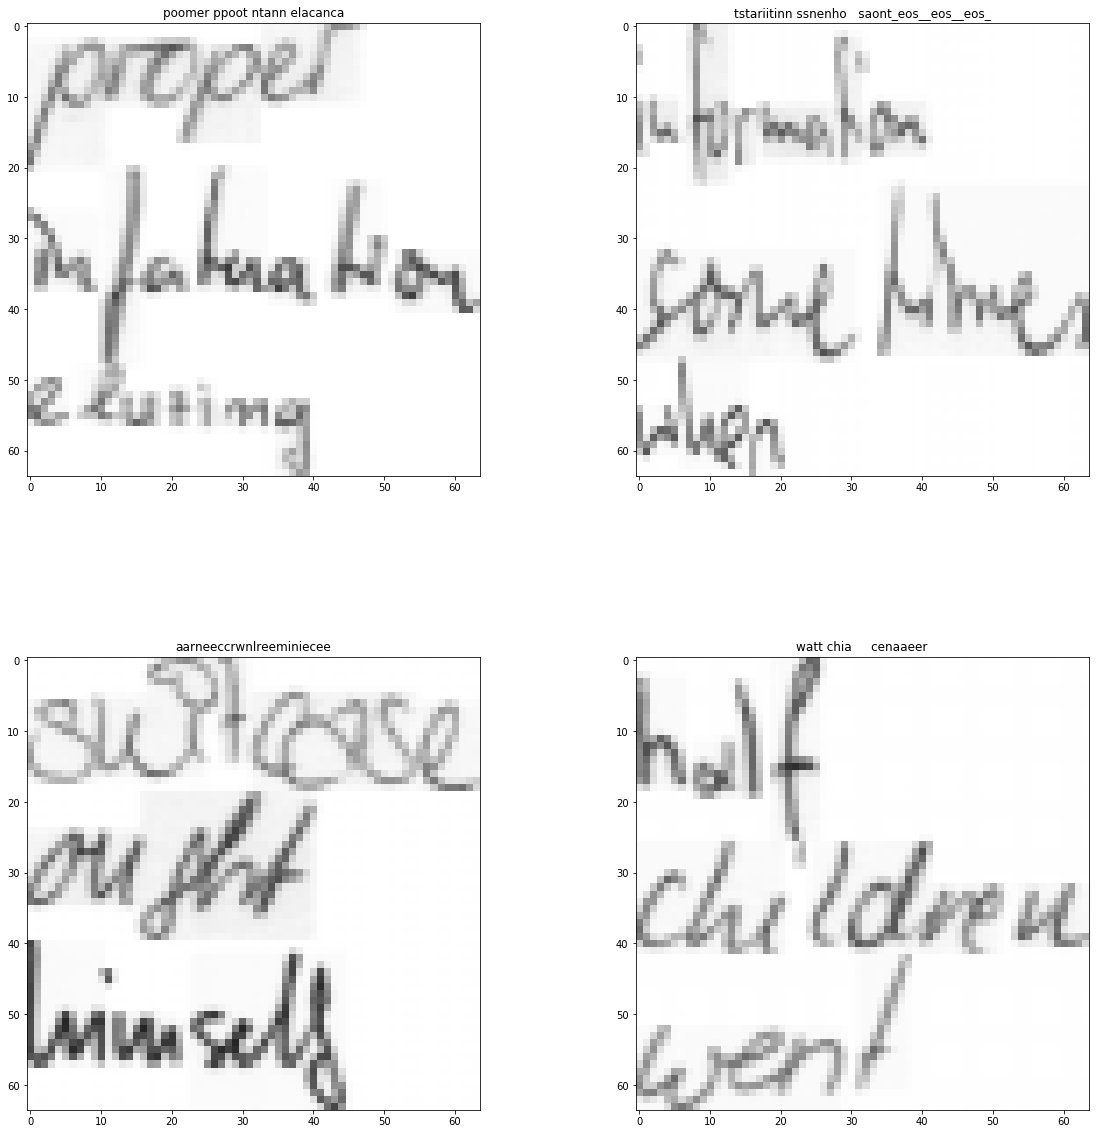

In [48]:
imgs = data.val_ds.denorm(x)

fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.4}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    p = char_label_text(res[i])
    ax=show_img(imgs[i], ax=ax, title=p)
    
# plt.tight_layout(pad=0.1)

### Source Attn

In [49]:
src_attn = source_attn().squeeze(1)
src_attn.shape

In [48]:
idx = 2
img = imgs[idx]
pred = res[idx]
img_attns = to_np(torch_scale_attns(src_attn[idx-1:idx])[0])

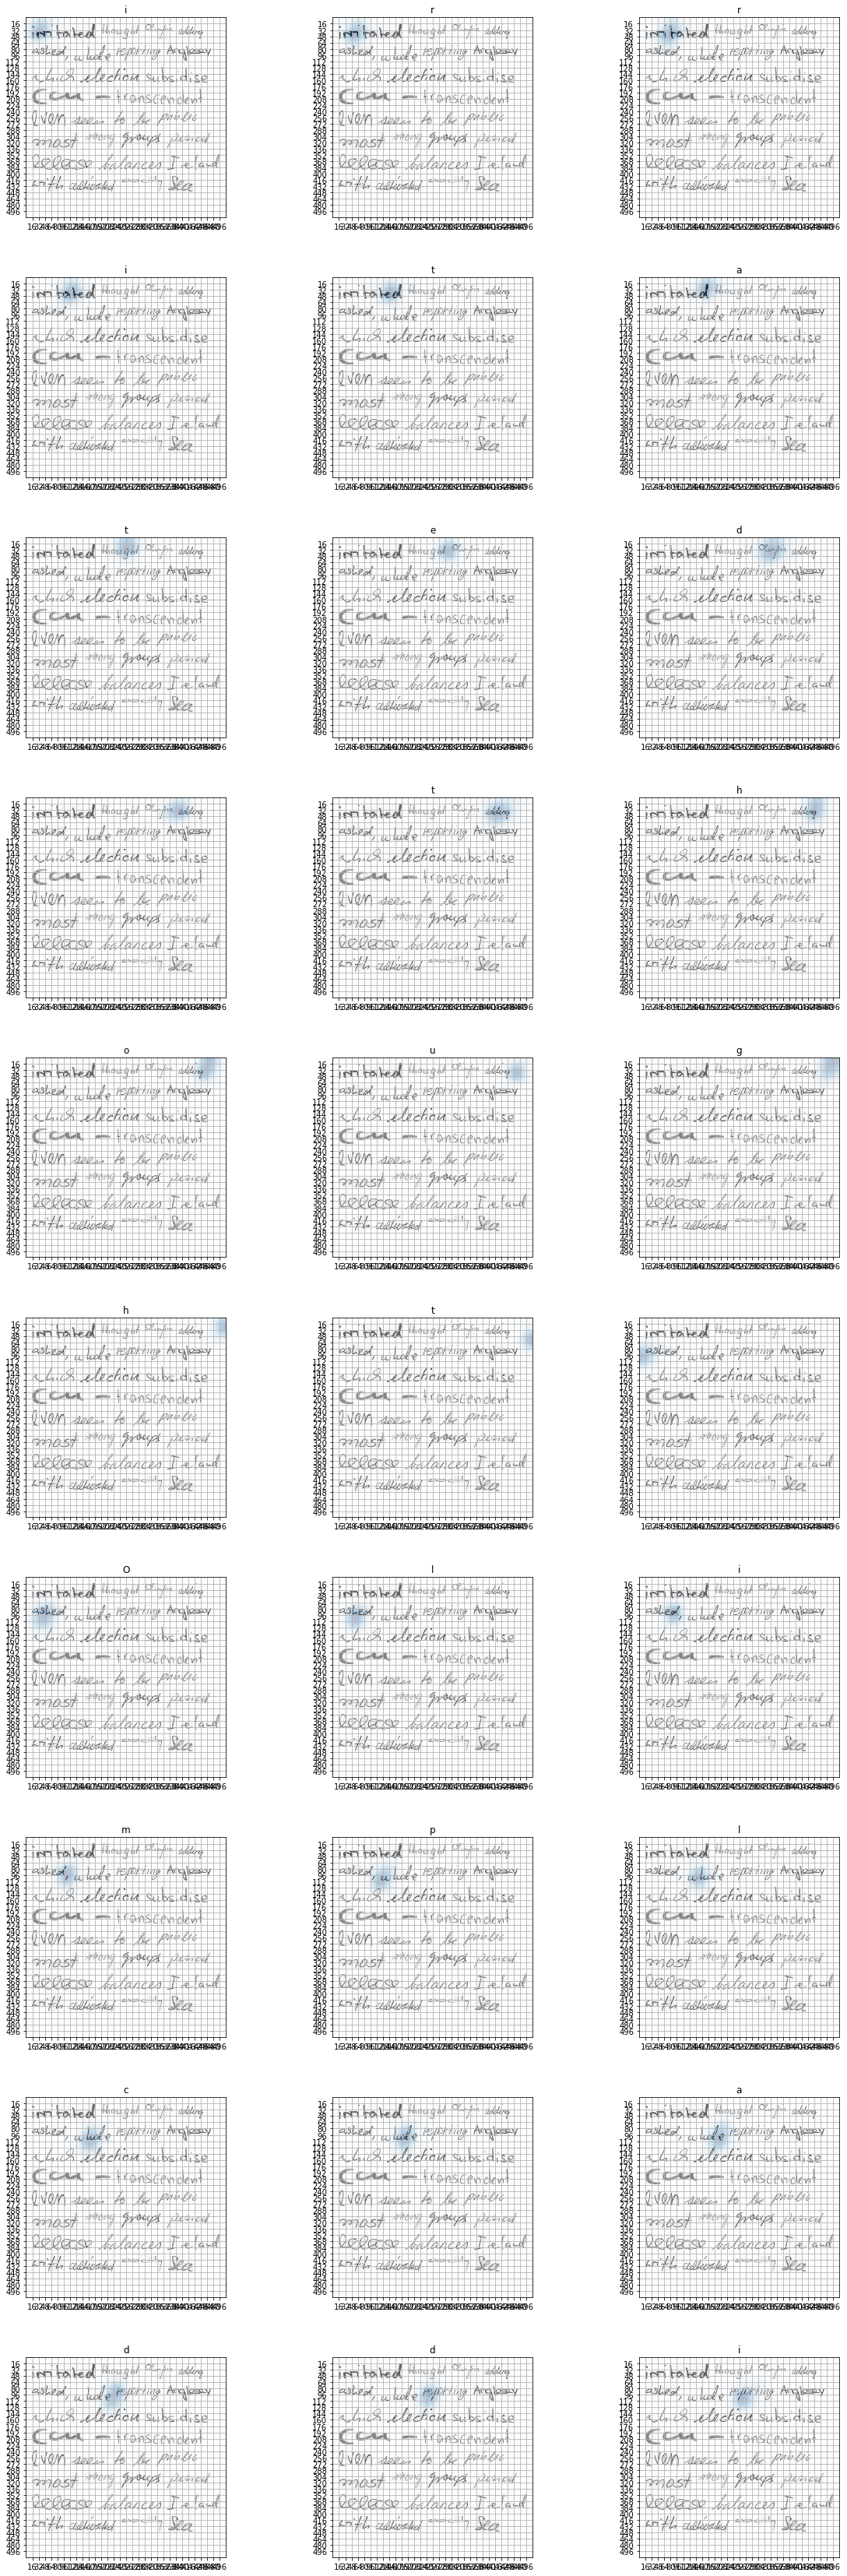

In [49]:
fig, axes = plt.subplots(10,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 60))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

### Target (self) Attn

Decoder Self Layer 1


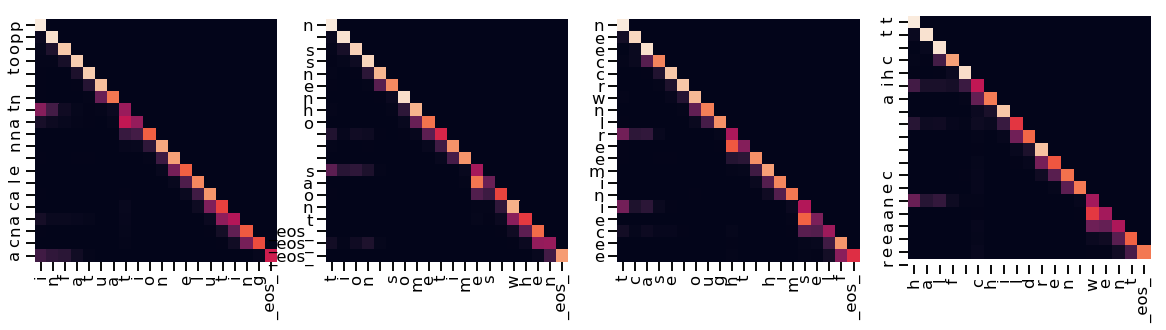

Decoder Self Layer 2


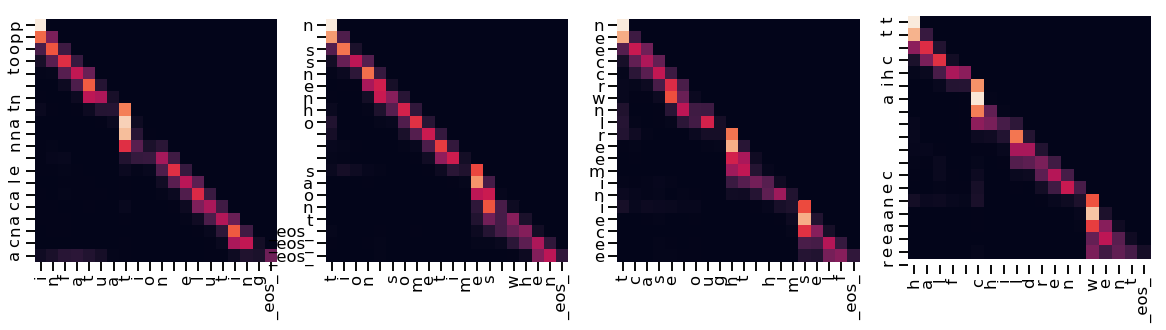

In [50]:
sns.set_context(context="talk")

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)

h = 0  #attn head
for layer in range(2):
    print("Decoder Self Layer", layer+1)
    fig, axes = plt.subplots(1,4, figsize=(20, 10))
    for i,ax in enumerate(axes.flat):  # multi example
        pred = char_split_text(res[i])[-20:]   # only last 20
        true = char_split_text(y[i])[-20:]     # only last 20
        draw(self_attn(layer)[i,h].data[:len(true), :len(true)], true, pred, ax=ax)
    plt.show()

### word attn

In [67]:
char_attn = src_attn.squeeze(1)
chars = pred.cpu().numpy()

In [86]:
arr = nonzero(chars)[:-1]         # remove zeros and eos char
ones = np.where(arr == 1)[0]+1    # find idxs of 1s and adds 1 (prepend 1 later on)
idxs = np.where(arr != 1)[0]
words = np.split(np.insert(arr, 0, 1), ones)   # prepend 1 to arr, split on ones
words = [w[1:] for w in words]    # remove all of the initial 1s

array([42, 73, 74,  1, 42, 56, 73, 67, 60, 56, 59,  1, 75, 63, 70, 76, 62, 63, 75,  1, 75, 63, 60,  1, 75,
       78, 70,  1, 47, 63, 70, 59, 60, 74, 64, 56, 69,  1, 71, 56, 73, 75, 64, 60, 74,  1, 63, 56, 59,  1,
       73, 60, 61, 76, 73, 60, 59,  1, 75, 70,  1, 56, 75, 60, 60, 69, 59,  1, 75, 63, 60,  1, 75, 56, 67,
       66, 74,  1, 57, 60, 58, 56, 76, 74, 60,  1, 48, 64, 73,  1, 75, 70, 80,  1, 63, 56, 59,  1, 61, 70,
       76, 69, 59,  1, 68, 60, 74, 74, 56, 62, 60, 74,  1, 74, 60, 69, 75,  1, 61, 73, 70, 68,  1, 75, 63,
       60,  1, 36, 70, 77, 60, 73, 69, 68, 60, 69, 75,  1, 78, 60, 73, 60,  1, 64, 76, 76, 69, 74, 56, 75,
       64, 74, 61, 56, 58, 14,  1, 75, 70, 73, 80,  1, 15,  1, 30,  1, 30, 61, 73, 64, 58, 56, 69,  1, 59,
       60, 67, 60, 62, 70, 75, 60, 74,  1, 75, 70,  1, 75, 63, 60,  1, 75, 56, 67, 66, 74,  1, 80, 60, 74,
       75, 60, 73, 14,  1, 75, 56, 80,  1, 58, 56, 67, 67, 60, 59,  1, 70, 69,  1, 42, 73, 15,  1, 42, 56,
       58, 68, 64, 67, 56, 56, 69,  1

In [108]:
[''.join(itos[c] for c in w) for w in words]

['Mrs',
 'Marlead',
 'thought',
 'the',
 'two',
 'Rhodesian',
 'parties',
 'had',
 'refured',
 'to',
 'ateend',
 'the',
 'talks',
 'because',
 'Sir',
 'toy',
 'had',
 'found',
 'messages',
 'sent',
 'from',
 'the',
 'Government',
 'were',
 'iuunsatisfac-',
 'tory',
 '.',
 'A',
 'African',
 'delegotes',
 'to',
 'the',
 'talks',
 'yester-',
 'tay',
 'called',
 'on',
 'Mr.',
 'Macmilaan',
 'to',
 'cease',
 'his',
 'degotiations',
 'with',
 'Iis',
 "tay's",
 'representative',
 ',',
 'Mr.',
 'Iulius',
 'treenfield',
 ',',
 'He',
 'was',
 'at',
 'Che-',
 'quers',
 'last',
 'wee--end',
 '.',
 'They',
 'said',
 'they',
 'reganded',
 'with',
 ',',
 'growing',
 'anger',
 ',',
 'the',
 'r',
 'aross',
 'and',
 'unconstitutional',
 'iiinterference',
 'by',
 'sir',
 "Roy's",
 'Federal',
 'Government',
 'in',
 'the',
 'thlls',
 't']

### Experiments with topk and thresholding attn

In [86]:
learn.model.img_enc

ResnetBase(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [76]:
# top 4 attn values
values,idxs = src_attn.topk(4)
dist = torch.zeros_like(src_attn)
dist.scatter_(-1, idxs, values)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [193]:
# threshold above 0.2 attn values
dist = F.threshold(src_attn, 0.2, 0)

In [77]:
img_attns = to_np(torch_scale_attns(dist)[0])

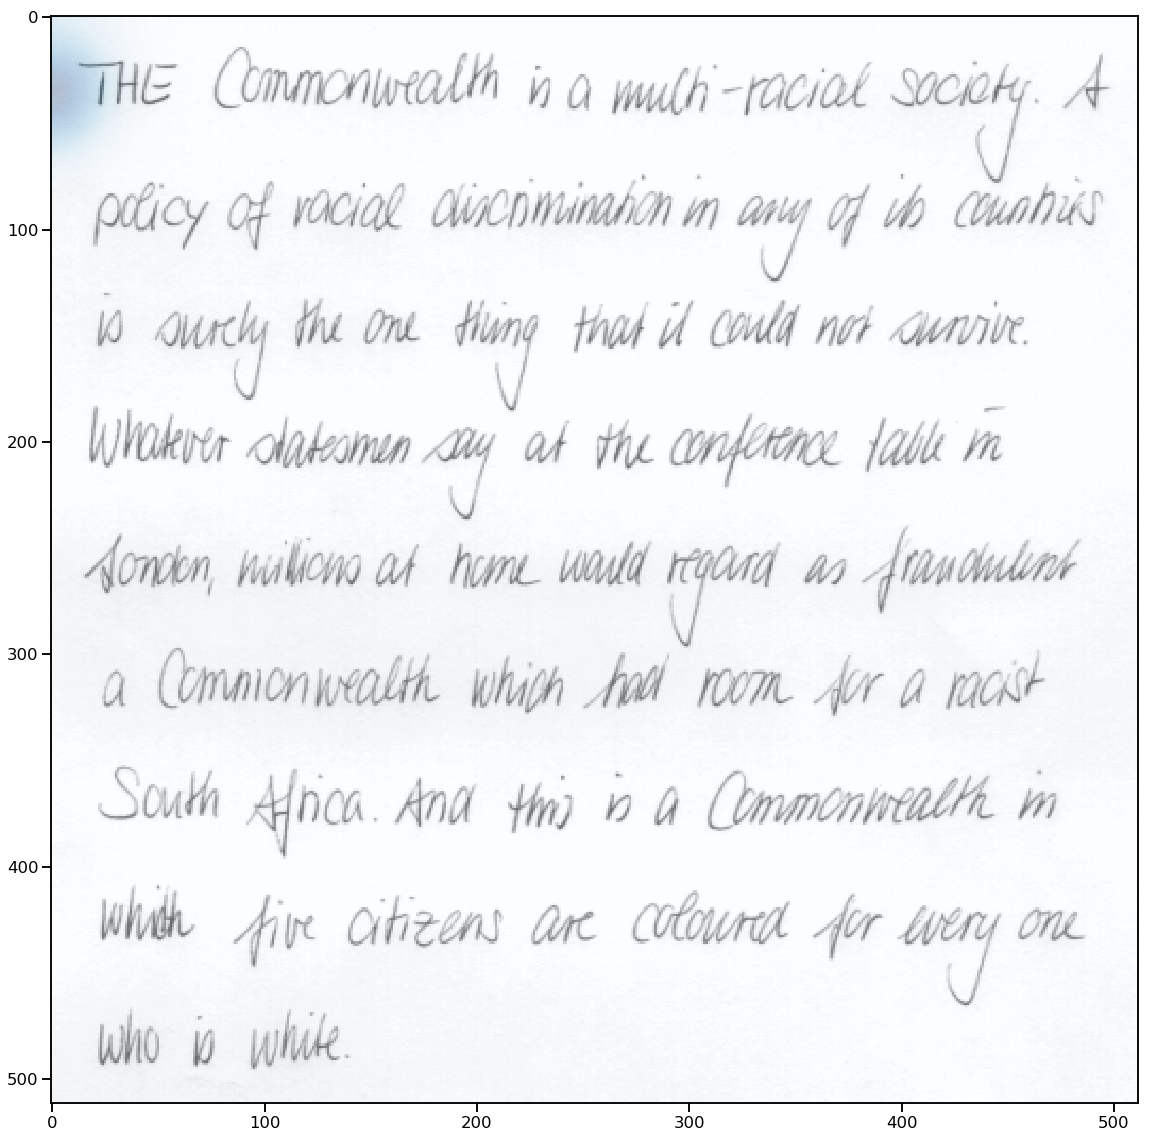

In [109]:
ax = show_img(img, figsize=(20,20))
for i in range(1):   #len(img_attns)
    a = g_filter(img_attns[i])
    ax.imshow(a, cmap='Blues', alpha=0.3)

## Decoding

In [134]:
x,y = next(iter(data.trn_dl))
inp,targ = x[:10],y[:10]  #x[-1:],y[-1:]

### Beam

In [124]:
def beam_search(net, inp, seq_len, k=5):
    with torch.no_grad():
        #bs = inp.size(0)
        feats = net.img_enc(inp)
        feats = feats.expand(k,-1,-1)    # expand tensor to bs*k 
        
        tgt = torch.ones((k,seq_len), dtype=torch.long, device=device)
        tgt_mask = subsequent_mask(tgt.size(-1))
        
        beam = torch.ones((k,1), device=device)
                
        res = []
        for i in tqdm(range(seq_len-1)):
            dec_outs = net.transformer(feats, tgt, tgt_mask)
            logits = net.transformer.generate(dec_outs[:,i])
            res.append(logits)
            probs,preds = torch.topk(F.softmax(logits, -1), k, dim=-1)  # (k, k)
            
            if (preds[:,0]==0).all(): break
            
            if i==0:    # first seq only
                beam = probs[0].unsqueeze(1)
                tgt[:,i+1] = preds[0]
            else:
                v,idxs = (beam*probs).flatten().topk(5)  #k*k
                beam = v.unsqueeze(1)

                current_tgt = tgt[:,:i+1].clone()
                for ii,idx in enumerate(idxs):
                    row,col = idx//k,idx%k   # row: beam of previous sequence,  col: current prediction
                    targ = torch.cat([current_tgt[row],preds[row,col][None]])
                    tgt[ii,:i+2] = targ

        out = torch.stack(res).transpose(1,0).contiguous()
        return out[0][None], tgt[0, 1:]

In [125]:
#beam
learn.model.eval()
g_preds, g_res = beam_search(learn.model, inp, seq_len)

 34%|███▍      | 15/44 [00:02<00:04,  6.11it/s]


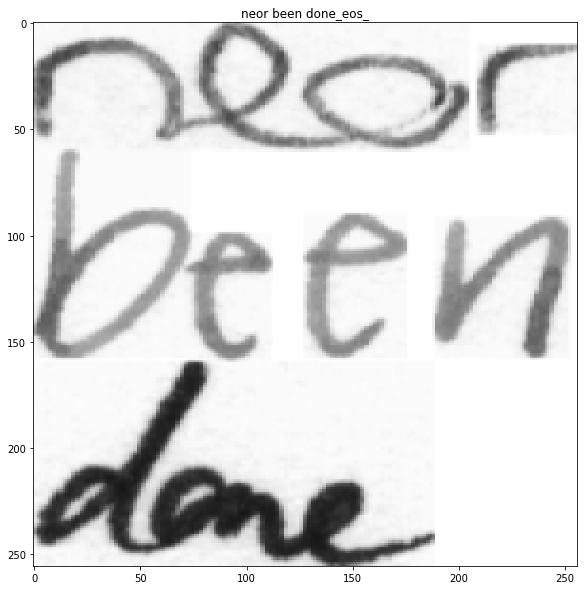

In [131]:
#beam search
img = data.val_ds.denorm(inp)[0]
t = char_label_text(g_res)
show_img(img, figsize=(10,10), title=t)

### Greedy

In [135]:
#greedy
learn.model.eval()
g_preds = learn.model.greedy_decode(inp, seq_len)
g_res = torch.argmax(g_preds, dim=-1)

100%|██████████| 250/250 [10:37<00:00,  2.82s/it]


In [136]:
learn.crit(g_preds, targ)
# bs: 10; test_; no val_idxs only data.trn_dl

# 3x1 256: 11.3161   'tfmr_3x1_256'
#    full: 5.8538    'tfmr_full_3x1_single_attn'

# 3x2 400: 55.6582   'tfmr_3x2'
#    full: 13.6992   'tfmr_full_3x2'

# lg 512:    'tfmr_lg2'
#   full: 337.2314   'tfmr_full_lg'

# pg 512: 68.66
# pg 800: 445.51

tensor(337.2314)

In [137]:
char_error_rate(g_preds, targ)
# 3x1 256: 0.12122   'tfmr_3x1_256'
#    full: 0.06835   'tfmr_full_3x1_single_attn'

# 3x2 400: 0.15940   'tfmr_3x2'
#    full: 0.03498   'tfmr_full_3x2'

# lg 512:        'tfmr_lg2'
#   full: 0.30408    'tfmr_full_lg'

# pg 512: 0.055
# pg 800: 0.252

0.30407914545561315

In [138]:
perplexity(g_preds,targ)
# 3x1 256: 20.6842   'tfmr_3x1_256'
#    full: 10.8831   'tfmr_full_3x1_single_attn'

# 3x2 400: 135.672   'tfmr_3x2'
#    full: 5.5703    'tfmr_full_3x2'

# lg 512:        'tfmr_lg2'
#   full: 294.7072   'tfmr_full_lg'


tensor(294.7072)

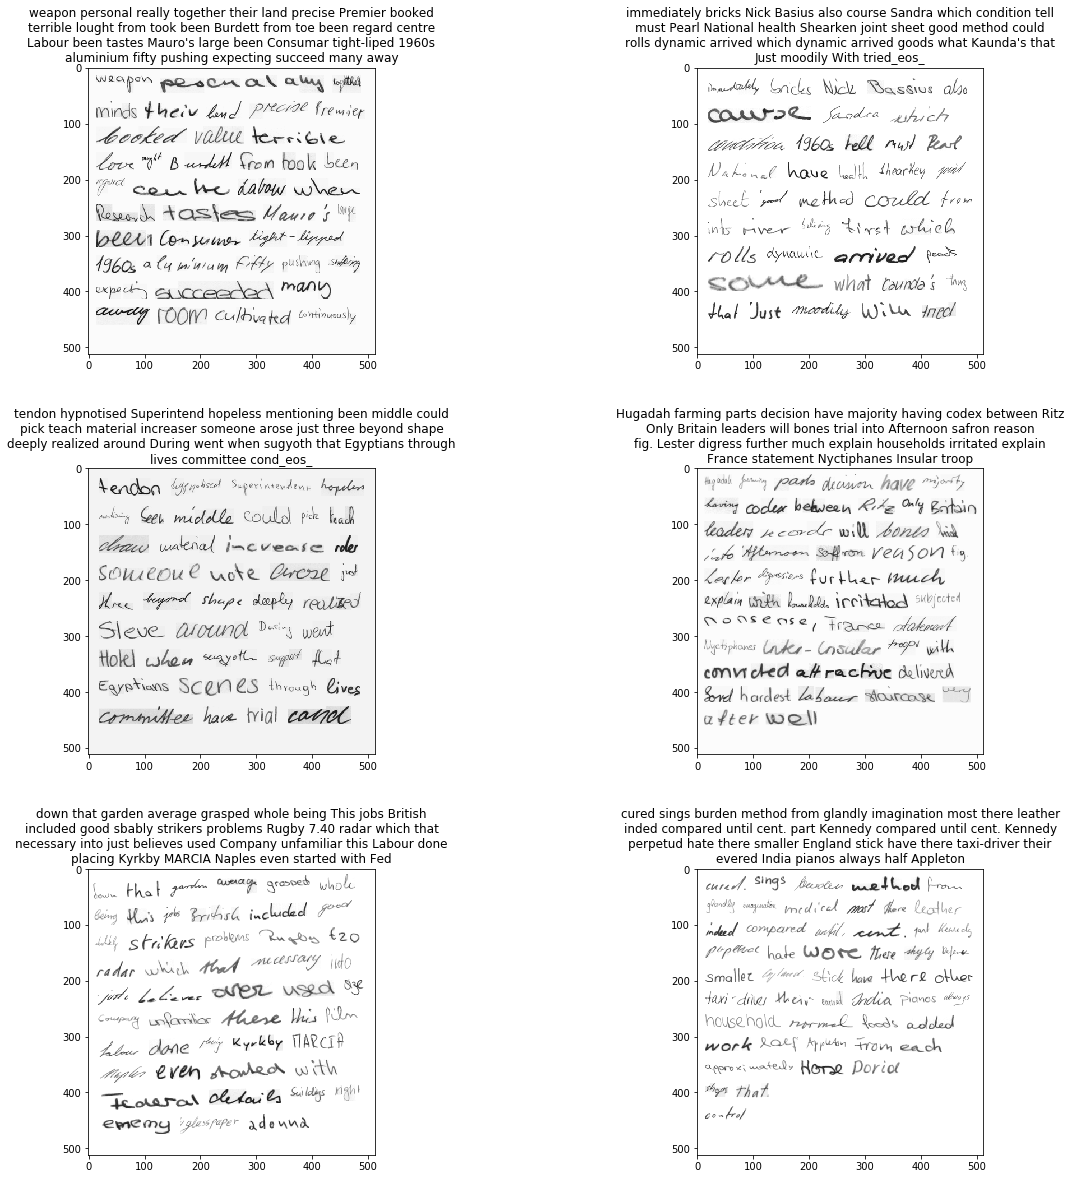

In [139]:
#greedy
imgs = data.val_ds.denorm(inp)

fig, axes = plt.subplots(3,2, gridspec_kw={'hspace': 0.4}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    p = char_label_text(g_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

### Attention

In [155]:
src_attn = source_attn(0).squeeze(1)
pred = g_res[0]
img_attns = to_np(torch_scale_attns(src_attn)[0])

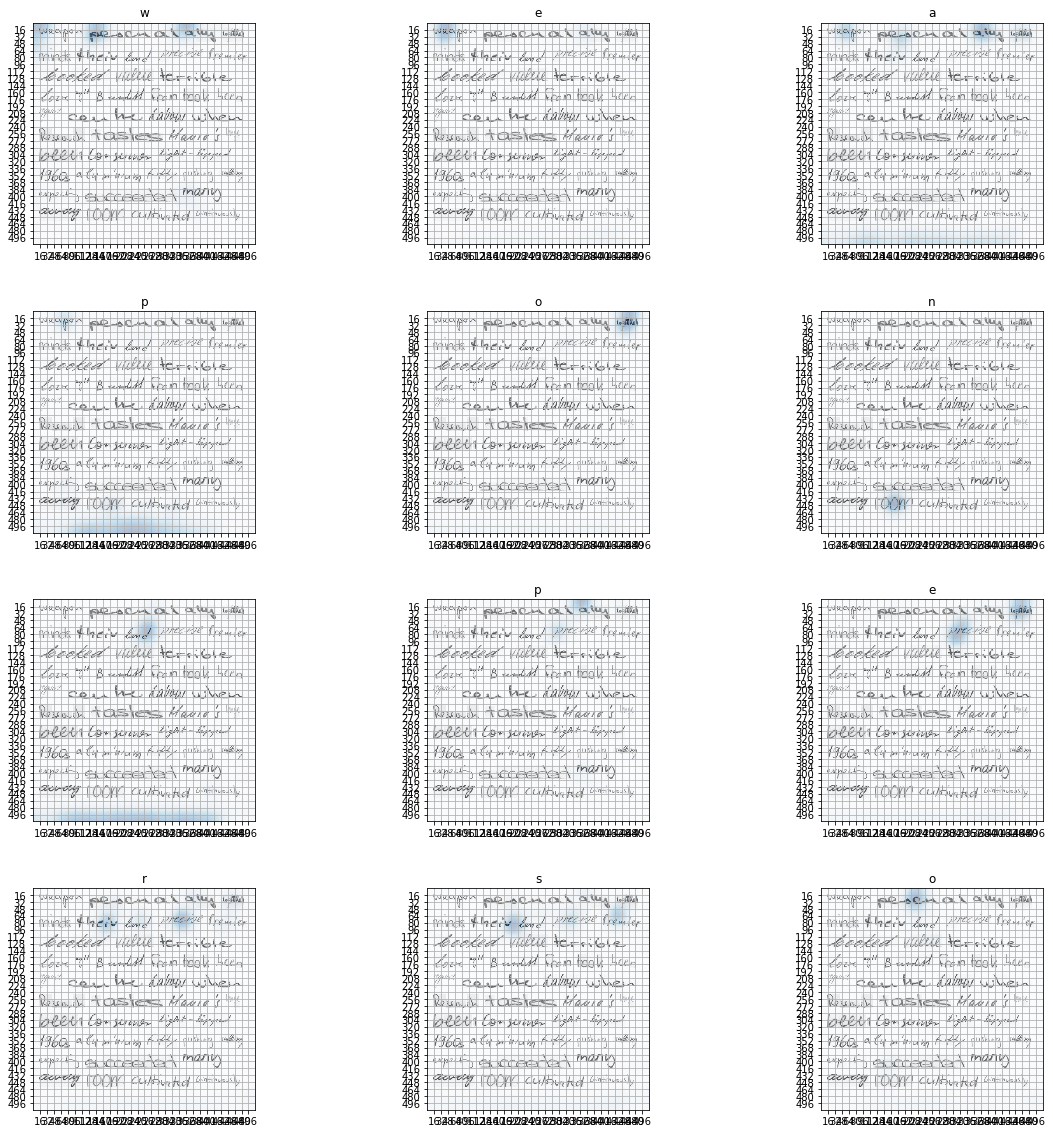

In [147]:
img = imgs[0]
fig, axes = plt.subplots(4,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

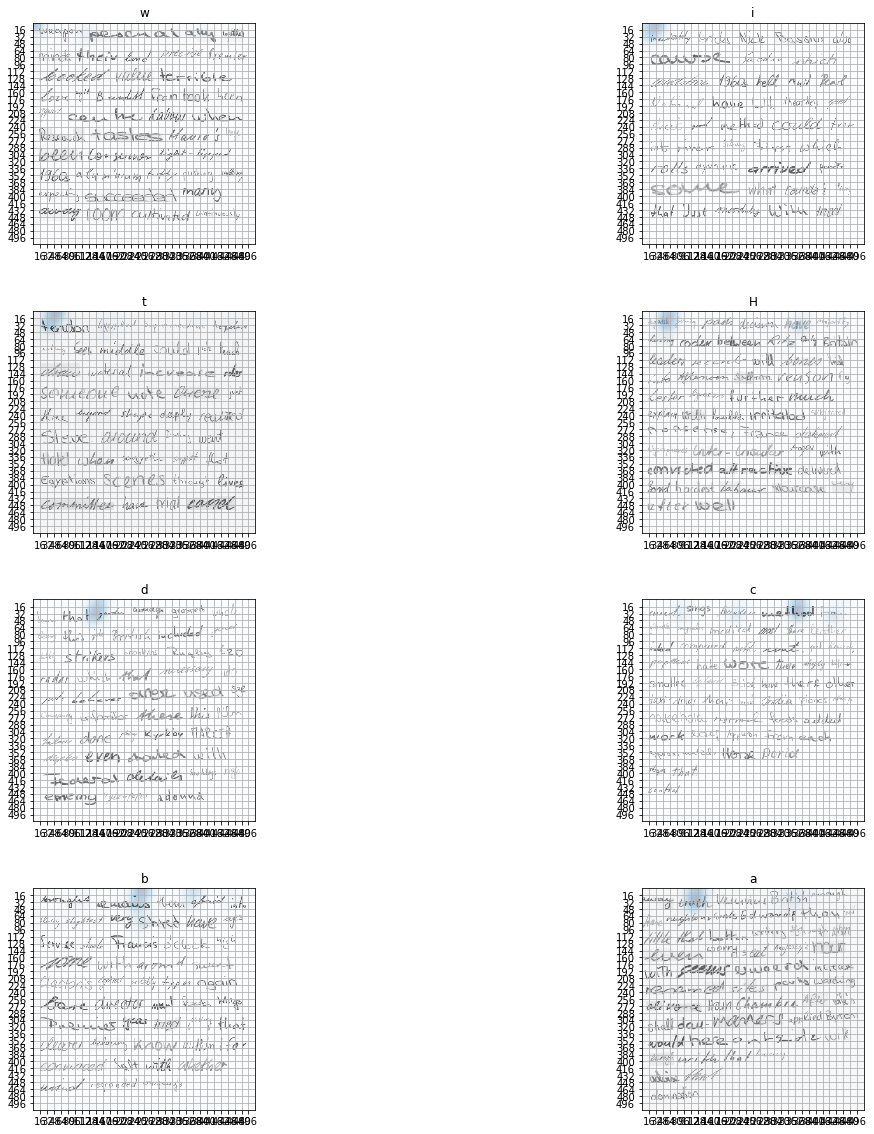

In [156]:
# first character attention for multiple imgs
fig, axes = plt.subplots(4,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(imgs[i], alpha=None)
    ax.imshow(a, cmap='Blues', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[g_res[i,0].item()])

In [160]:
src_self_attn = source_self_attn(0).squeeze(1)
pred = g_res[0]
img_attns = to_np(torch_scale_attns(src_attn)[0])